In [3]:
# Attempt to apply SNAIL/Attention to regress ages

# Bad subjects
# Bad IDs: 605515760919, 601983541597

# Load split

import pickle

badIDs = [605515760919, 601983541597]

with open('../../Splits/RegressionAllTasks/split1.bin', 'rb') as f:
    d = pickle.load(f)
    train = []
    trainDirty = d['train']
    test = []
    testDirty = d['test']
    
    # Remove bad subjects
    for subj in trainDirty:
        if subj['ID'] not in badIDs:
            train.append(subj)
            
    for subj in testDirty:
        if subj['ID'] not in badIDs:
            test.append(subj)
    
print(len(train))
print(len(test))
print(train[0])

466
156
{'meta': {'AgeInMonths': 146, 'Gender': 'F', 'Ethnicity': 'AFRICAN', 'AgeGroupID': 2, 'AgeGroupEdge1': 144, 'AgeGroupEdge2': 180}, 'rest': '30', 'nback': '31', 'emoid': '31', 'ID': 600262185931}


In [91]:
# Load data

def loadTimeseries(_id, _dir):
    ts = None
    with open('{:s}/{:d}.bin'.format(_dir, _id), 'rb') as f:
        ts = pickle.load(f)
    return ts

train_rest_ts = [loadTimeseries(int(subj['nback']), '../../nback_fmri_power264/timeseries') for subj in train]
# train_nback_ts = [loadTimeseries(int(subj['nback']), '../../nback_fmri_power264/timeseries') for subj in train]
# train_emoid_ts = [loadTimeseries(int(subj['emoid']), '../../emoid_fmri_power264/timeseries') for subj in train]

test_rest_ts = [loadTimeseries(int(subj['nback']), '../../nback_fmri_power264/timeseries') for subj in test]
# test_nback_ts = [loadTimeseries(int(subj['nback']), '../../nback_fmri_power264/timeseries') for subj in test]
# test_emoid_ts = [loadTimeseries(int(subj['emoid']), '../../emoid_fmri_power264/timeseries') for subj in test]

print('Complete')

Complete


In [92]:
# Normalize data

import numpy as np

def normalizeSubjects(subjects):
    for i in range(len(subjects)):
        subj = subjects[i]
        subj -= np.mean(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        subj /= np.std(subj, axis=1, keepdims=True)@np.ones([1,subj.shape[1]])
        if np.sum(np.isnan(subj)) > 0:
            print(i)
        if np.sum(np.isinf(subj)) > 0:
            print(i)

normalizeSubjects(train_rest_ts)
# normalizeSubjects(train_nback_ts)
# normalizeSubjects(train_emoid_ts)

normalizeSubjects(test_rest_ts)
# normalizeSubjects(test_nback_ts)
# normalizeSubjects(test_emoid_ts)

print('Complete')

Complete


In [93]:
# Create labels (ages)

y_train = np.vstack([subj['meta']['AgeInMonths'] for subj in train])
y_test = np.vstack([subj['meta']['AgeInMonths'] for subj in test])

print('Complete')

Complete


In [94]:
# Apply PCA

from sklearn.decomposition import PCA

pca = PCA(80)
pca.fit(np.vstack([subj.T for subj in train_rest_ts]))

train_rest_ts_pca = [pca.transform(subj.T).T for subj in train_rest_ts]
test_rest_ts_pca = [pca.transform(subj.T).T for subj in test_rest_ts]

print('Complete')

Complete


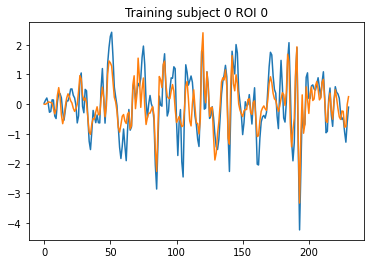

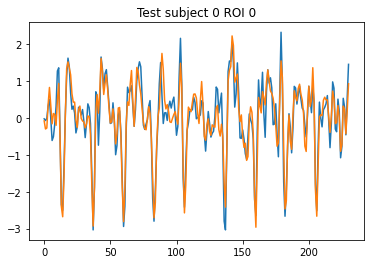

In [95]:
# Test PCA

import matplotlib.pyplot as plt

reconTrain = pca.inverse_transform(train_rest_ts_pca[0].T).T
reconTest = pca.inverse_transform(test_rest_ts_pca[0].T).T

plt.plot(train_rest_ts[0][0,:])
plt.plot(reconTrain[0,:])
plt.title('Training subject 0 ROI 0')
plt.show()

plt.plot(test_rest_ts[0][0,:])
plt.plot(reconTest[0,:])
plt.title('Test subject 0 ROI 0')
plt.show()

In [96]:
# Torch

import torch
import torch.nn as nn
import torch.nn.functional as F

train_rest_ts_torch = [torch.from_numpy(subj).T.float() for subj in train_rest_ts_pca]
test_rest_ts_torch = [torch.from_numpy(subj).T.float() for subj in test_rest_ts_pca]

print('Complete')

Complete


In [85]:
# SNAIL

nt = train_rest_ts_torch[0].shape[0]
nc = 10
nh = 5
nrois = 80

class Snail(nn.Module):
    def __init__(self):
        super(Snail, self).__init__()
        self.conv1 = nn.Conv2d(1, nc, [7, 1])
        self.attn1 = nn.MultiheadAttention(nc*nrois, nh)
        self.fc1 = nn.Linear(10*nc*nrois, 1)
        
    def forward(self, x):
        nb = x.shape[0]
        x = F.relu(self.conv1(x))
        x = x.permute(2,0,1,3)
        x = x.reshape(nt-6, nb, nc*nrois)
        x, _ = self.attn1(x,x,x)
        x = x[0:10,:,:]
        x = x.permute(1,0,2)
        x = x.reshape(nb, 10*nc*nrois)
        x = self.fc1(x)
        return x
        
snail = Snail()
optim = torch.optim.Adam(snail.parameters(), lr=2e-3)

In [212]:
# Pathological MLP test

nt = train_rest_ts_torch[0].shape[0]
nrois = train_rest_ts_torch[0].shape[1]

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(nt*nrois,1)
    
    def forward(self, x):
        x = x.view(x.shape[0], nt*nrois)
        return self.fc1(x)
    
snail = MLP()
optim = torch.optim.Adam(snail.parameters(), lr=1e-3, weight_decay=10)

In [97]:
# Check against most successful model

nt = train_rest_ts_torch[0].shape[0]
nc = 10
nrois = 80

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.cl1 = nn.Conv2d(1,nc,(5,nrois)) # Output size 10x1x(nt-4)
        # Maybe try batch norm https://arxiv.org/abs/1502.03167
        self.bn1 = nn.BatchNorm2d(nc)
        # Maybe try dropout
        # Maybe try maxpool2d
        self.cl2 = nn.Conv2d(nc,nc,(5,1)) # Output size 10x1x(nt-8)
        #self.mp1 = nn.MaxPool2d((1,3),2)
        # Maybe try pyramid pooling to allow different size input lengths
        #self.fc1 = nn.Linear(int(nc*(nt-10)/2), 50)
        self.fc1 = nn.Linear(nc*(nt-8), 50)
        self.fc2 = nn.Linear(50,1)
    
    def forward(self, x):
        x = F.relu(self.cl1(x))
        x = self.bn1(x)
        x = F.relu(self.cl2(x))
        #x = self.mp1(x)
        x = F.relu(self.fc1(x.reshape(x.shape[0],-1)))
        x = F.relu(self.fc2(x))
        return x
    
snail = CNN()
optim = torch.optim.Adam(snail.parameters(), lr=2e-3)

In [98]:
import random

N = len(train_rest_ts_torch)-1
running = 0
nEpoch = 3000
pPeriod = 10
nBatch = 10

for epoch in range(nEpoch):
    batch = []
    truth = torch.zeros(nBatch)
    for i in range(nBatch):
        idx = random.randint(0,N)
        subj = train_rest_ts_torch[idx]
        batch.append(subj.unsqueeze(0).unsqueeze(0))
        truth[i] = y_train[idx,0]
    optim.zero_grad()
    pred = snail(torch.cat(batch)).view(nBatch)
    loss = torch.sum((truth-pred)**2)
    loss.backward()
    optim.step()
    running += loss
    if epoch % pPeriod == 0 or epoch == nEpoch-1:
        if epoch != 0:
            running = running/pPeriod
        print('epoch {:d} loss={:f}'.format(epoch, running))
        running = 0

print('Finished training')

epoch 0 loss=322654.125000
epoch 10 loss=304254.812500
epoch 20 loss=133976.375000
epoch 30 loss=26518.378906
epoch 40 loss=17413.111328
epoch 50 loss=11355.994141
epoch 60 loss=9159.458984
epoch 70 loss=10108.205078
epoch 80 loss=6294.935059
epoch 90 loss=7304.141602
epoch 100 loss=6244.754395
epoch 110 loss=5291.118652
epoch 120 loss=3735.333984
epoch 130 loss=4540.041992
epoch 140 loss=3409.164062
epoch 150 loss=5630.492676
epoch 160 loss=6090.914062
epoch 170 loss=5452.220215
epoch 180 loss=4376.956055
epoch 190 loss=4488.965820
epoch 200 loss=3141.956543
epoch 210 loss=3238.430908
epoch 220 loss=2305.640381
epoch 230 loss=3370.627686
epoch 240 loss=2949.770264
epoch 250 loss=3972.597168
epoch 260 loss=3236.826904
epoch 270 loss=2198.998779
epoch 280 loss=2696.057373
epoch 290 loss=1913.280273
epoch 300 loss=1740.057983
epoch 310 loss=1582.393921
epoch 320 loss=2369.592285
epoch 330 loss=2186.229736
epoch 340 loss=1539.118408
epoch 350 loss=2093.720703
epoch 360 loss=1744.077148
ep

[[1.         0.58471388]
 [0.58471388 1.        ]]
2.4686333101380464
1.9227530039273777


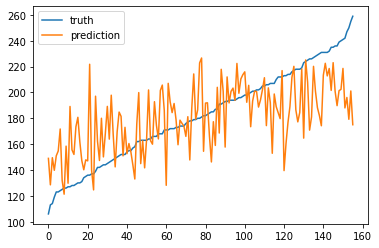

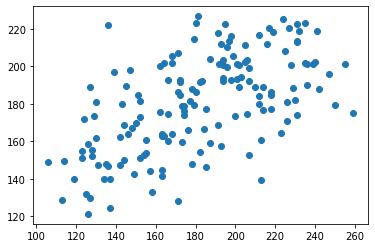

In [99]:
# Get predictions

y = y_test
X = test_rest_ts_torch
N = len(y)

pred = np.zeros(N)
y1 = np.zeros(N) # rmse
y2 = np.zeros(N) # mae
for i in range(N):
    pred[i] = snail(X[i].unsqueeze(0).unsqueeze(0))[0]
    y1[i] = (y[i,0]-pred[i])**2
    y2[i] = abs(y[i,0]-pred[i])
    
print(np.corrcoef(y.flatten(), pred))
print((y1.sum()/N)**0.5/12)
print(y2.sum()/N/12)
# print(y1)
# print(y2)

idcs = np.argsort(y,axis=0)
plt.plot(y[idcs,0], label='truth')
plt.plot(pred[idcs], label='prediction')
plt.legend()
plt.show()

plt.scatter(y.flatten(), pred)
plt.show()

In [173]:
# Test pytorch views

a = torch.Tensor([[[[1,2,3],[4,5,6]]],[[[7,8,9],[10,11,12]]]])
print(a)

tensor([[[[ 1.,  2.,  3.],
          [ 4.,  5.,  6.]]],


        [[[ 7.,  8.,  9.],
          [10., 11., 12.]]]])


In [174]:
print(a.shape)

torch.Size([2, 1, 2, 3])


In [176]:
print(a.view(a.shape[0], 2, 3))

tensor([[[ 1.,  2.,  3.],
         [ 4.,  5.,  6.]],

        [[ 7.,  8.,  9.],
         [10., 11., 12.]]])


In [25]:
import torch

b = torch.rand(2,2,3,2)
print(b)
# print(b[0,0,1,0])
# print(b[0,0,:,:])
# b = b.view(2,2,4)
# print(b[0,:,:].view(1,2,4))
b = b.reshape(2,2,6)
b = b.reshape(2,2,3,2)
print(b)

tensor([[[[0.0741, 0.1050],
          [0.2024, 0.4701],
          [0.4174, 0.7828]],

         [[0.8476, 0.3635],
          [0.6898, 0.5775],
          [0.9654, 0.0378]]],


        [[[0.6816, 0.7941],
          [0.1700, 0.5639],
          [0.7648, 0.6755]],

         [[0.7345, 0.5572],
          [0.8543, 0.4595],
          [0.5570, 0.9745]]]])
tensor([[[[0.0741, 0.1050],
          [0.2024, 0.4701],
          [0.4174, 0.7828]],

         [[0.8476, 0.3635],
          [0.6898, 0.5775],
          [0.9654, 0.0378]]],


        [[[0.6816, 0.7941],
          [0.1700, 0.5639],
          [0.7648, 0.6755]],

         [[0.7345, 0.5572],
          [0.8543, 0.4595],
          [0.5570, 0.9745]]]])


In [48]:
with open('../../AllSubjectsMeta.bin', 'rb') as f:
    allsubs = pickle.load(f)

# print(list(allsubs.keys()))
print(allsubs[600009963128])

{'meta': {'AgeInMonths': 116, 'Gender': 'F', 'Ethnicity': 'CAUCASIAN/WHITE', 'AgeGroupID': 1, 'AgeGroupEdge1': 103, 'AgeGroupEdge2': 144}, 'rest': '0', 'nback': '0', 'emoid': '0'}
